In [1]:
from typing import Any, List, Optional, Tuple, Union
import numpy as np
from magic_pen.config import DEVICE
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform
from segment_any_change.embedding import (
    compute_mask_embedding,
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_items import (
    FilteringType,
    ImgType,
    ListProposal,
)
from segment_any_change.matching import (
    BitemporalMatching,
    neg_cosine_sim,
)
import torch
import torchvision
from torch.nn import functional as F
import kornia as K
from segment_any_change.model import BiSam
from segment_any_change.sa_dev_v0.predictor import SamPredictor
from torch.utils.data import DataLoader
from segment_any_change.utils import *
import matplotlib.pyplot as plt
from magic_pen.config import project_path
from magic_pen.utils_io import make_path
import os

import logging

# TO DO : define globally
logging.basicConfig(format="%(asctime)s - %(levelname)s ::  %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from segment_any_change.inference import partial_inference, infer_on_sample

In [3]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

In [4]:
img_B = load_img(path_B)
img_A = load_img(path_A)

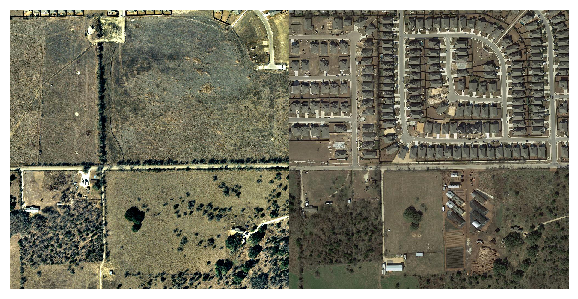

In [5]:
show_pair_img(img_A, img_B)

In [6]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

output = infer_on_sample(A_path=path_A, 
                B_path=path_B, 
                label_path=path_label, 
                model=None)

2024-05-31 15:08:25,356 - INFO ::  build BiSam


torch.Size([1, 3, 1024, 1024])
BATCH SIZE : 1
Function forward Took 3.8076 seconds
sparse_embeddings: torch.Size([2, 100, 2, 256])
dense_embeddings: torch.Size([2, 100, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([2, 100, 5, 256])
tokens shape : torch.Size([2, 100, 7, 256])
img_embedding (src) : torch.Size([2, 100, 256, 64, 64])
--in transformer--
src : torch.Size([2, 100, 256, 64, 64])
pos_src : torch.Size([2, 100, 256, 64, 64])
tokens : torch.Size([2, 100, 7, 256])
- In transf src : torch.Size([2, 100, 4096, 256])
- In transf image_pe : torch.Size([2, 100, 4096, 256])
out transformer
hs shape : torch.Size([2, 100, 7, 256])
src shape : torch.Size([2, 100, 4096, 256])
iou out shape : torch.Size([2, 100, 256])
masks tokens out shape : torch.Size([2, 100, 4, 256])
upscaled src tokens out shape : torch.Size([2, 100, 32, 256, 256])
hyper in shape : torch.Size([2, 100, 4, 32])
 mask_low : torch.Size([2, 100, 4, 256, 256])
Function predict_masks_ba

2024-05-31 15:08:34,285 - INFO ::  Function generate Took 7.6354 seconds


 filter stability_score : 9
 filter mask_threshold : 9
ATTACH 6 masks
 filter iou_th : 34
 filter stability_score : 9
 filter mask_threshold : 9
ATTACH 6 masks


2024-05-31 15:08:34,452 - INFO ::  nan values ci 0
2024-05-31 15:08:34,453 - INFO ::  nan values ci1 1
2024-05-31 15:08:34,520 - INFO ::  Function proposal_matching Took 0.0663 seconds
2024-05-31 15:08:34,525 - INFO ::  Function run Took 7.8750 seconds


[-0.8969989334879059, -0.9270119346763646, -0.6657703822117543, -0.6383834586720208, -0.5456558115072079, -0.5479500309568136]
[-0.9101870412061336, nan, -0.67089236287283, -0.9183239556508883, -0.5658389717785751, -0.41253507560420216]
[22.026280093615156, 48.25854581336886, 50.328616569228366, 56.9305091059965, 56.773510116668824, 47.86402479327023, 23.893257631956235, 23.6822173787546, 55.53942869130134, 65.63581591825881]


In [7]:
output.keys()

dict_keys(['pred', 'batch'])

In [8]:
output["batch"]["img_A"].shape

torch.Size([1, 3, 1024, 1024])

In [9]:
output["pred"]["masks"].shape

torch.Size([1, 10, 1024, 1024])

In [10]:
def show_prediction_sample(output: Dict):
    masks = output["pred"]["masks"].cpu().squeeze(0)
    img_A = output["batch"]["img_A"].cpu().squeeze(0)
    img_B = output["batch"]["img_B"].cpu().squeeze(0)
    label = output["batch"]["label"].cpu().squeeze(0)

    if masks.ndim == 3:
        masks = torch.sum(masks, dim=0)
    fig, axs = plt.subplots(ncols=4, squeeze=False, figsize=(10, 10))
    
    for i, sample in enumerate(zip([img_A, img_B, label, masks], ["img_A", "img_B", "label", "masks_agg"])):
        img, name = sample
        if name.startswith("im"):
            img = to_numpy(img, transpose=True) / 255
            axs[0, i].imshow(img)

        else:
            img = to_numpy(img, transpose=False)
            axs[0, i].imshow(img, cmap="grey")

        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(name)

In [11]:
masks = output["pred"]["masks"].cpu().squeeze(0)
label = output["batch"]["label"].cpu().squeeze(0)

In [12]:
def get_metrics_units_counts(masks, label, eps=1e-5):
    """masks and labels need to be binary"""
    if masks.ndim > 2:
        masks = torch.sum(masks, axis=0).to(torch.int8)
    # ensure 0, 1 values
    MAX = torch.max(label)
    label = label / MAX
    
    output = masks.view(-1, )
    target = label.view(-1, ).float()

    tp = torch.sum(output * target)  # TP
    fp = torch.sum(output * (1 - target))  # FP
    fn = torch.sum((1 - output) * target)  # FN
    tn = torch.sum((1 - output) * (1 - target))  # TN

    return tp, fp, fn


def get_metrics_units_px(masks, label, eps=1e-5):
    """masks and labels need to be binary"""
    if masks.ndim > 2:
        masks = torch.sum(masks, axis=0).to(torch.int8)
    # ensure 0, 1 values
    MAX = torch.max(label)
    label = label / MAX

    tp = masks * label  # TP
    fp = masks * (1 - label) # FP
    fn = (1 - masks) * label  # FN
    return tp, fp, fn

def plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay"):

    overlay = np.zeros((*tp.shape, 3), dtype=np.uint8)
    tp = to_numpy(tp, transpose=False)
    tfp = to_numpy(fp, transpose=False)
    fn = to_numpy(fn, transpose=False)

    # tps in green
    overlay[tp == 1] = [0, 255, 0]
    
    # fn in red
    overlay[fn == 1] = [255, 0, 0]
    
    # fp orange
    overlay[fp == 1] = [255, 165, 0]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay, alpha=0.5)  # overlay with transparency
    plt.title(title)
    plt.axis('off')
    plt.show()

    # pixel_acc = (tp + tn + self.eps) / (tp + tn + fp + fn + self.eps)
    #     dice = (2 * tp + self.eps) / (2 * tp + fp + fn + self.eps)
    #     precision = (tp + self.eps) / (tp + fp + self.eps)
    #     recall = (tp + self.eps) / (tp + fn + self.eps)
    #     specificity = (tn + self.eps) / (tn + fp + self.eps)


torch.Size([10, 1024, 1024])


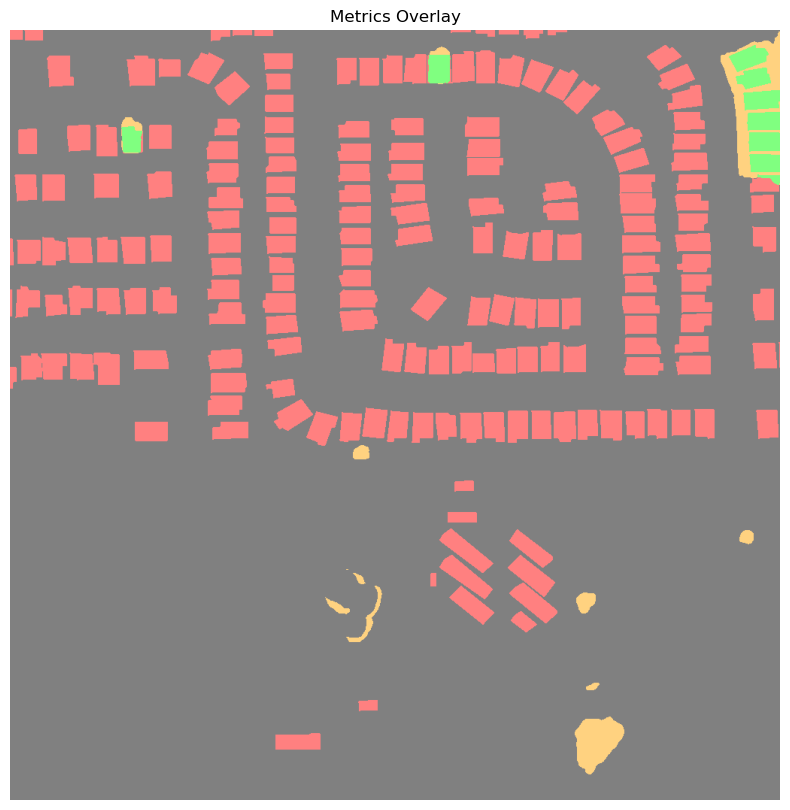

In [13]:
print(masks.shape)
tp, fp, fn = get_metrics_units_px(masks, label)
plot_metrics_units_px(tp, fp, fn, title="Metrics Overlay")

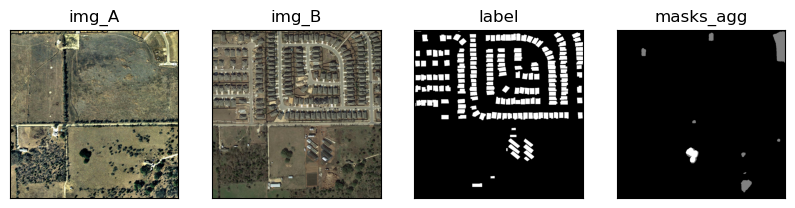

In [14]:
show_prediction_sample(output)

* Issue, not same as before. Check bug

### Check objects generation

In [20]:
from segment_any_change.masks.mask_generator import SegAnyMaskGenerator
from segment_any_change.inference import load_default_sam_params
from magic_pen.data.loader import DataSample

params = load_default_sam_params()

sam = load_sam(
            model_type=params.model_type, 
            model_cls=BiSam,
            version="dev", 
            device=DEVICE
            )

mask_generator = SegAnyMaskGenerator(sam, 
                                    points_per_side=params.points_per_side,
                                    points_per_batch=params.points_per_batch,
                                    pred_iou_thresh=params.pred_iou_thresh,
                                    stability_score_thresh=params.stability_score_thresh,
                                    stability_score_offset=params.stability_score_offset,
                                    box_nms_thresh=params.box_nms_thresh,
                                    min_mask_region_area=params.min_mask_region_area)


item = DataSample(A_path=path_A, 
                    B_path=path_B, 
                    label_path=path_label)
    
ds = BiTemporalDataset(items=item, transform=DefaultTransform())
dloader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)
batch = next(iter(dloader))


img_anns = mask_generator.generate(batch)


2024-05-31 15:13:45,688 - INFO ::  build BiSam


torch.Size([1, 3, 1024, 1024])
BATCH SIZE : 1
Function forward Took 3.5132 seconds
sparse_embeddings: torch.Size([2, 100, 2, 256])
dense_embeddings: torch.Size([2, 100, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([2, 100, 5, 256])
tokens shape : torch.Size([2, 100, 7, 256])
img_embedding (src) : torch.Size([2, 100, 256, 64, 64])
--in transformer--
src : torch.Size([2, 100, 256, 64, 64])
pos_src : torch.Size([2, 100, 256, 64, 64])
tokens : torch.Size([2, 100, 7, 256])
- In transf src : torch.Size([2, 100, 4096, 256])
- In transf image_pe : torch.Size([2, 100, 4096, 256])
out transformer
hs shape : torch.Size([2, 100, 7, 256])
src shape : torch.Size([2, 100, 4096, 256])
iou out shape : torch.Size([2, 100, 256])
masks tokens out shape : torch.Size([2, 100, 4, 256])
upscaled src tokens out shape : torch.Size([2, 100, 32, 256, 256])
hyper in shape : torch.Size([2, 100, 4, 32])
 mask_low : torch.Size([2, 100, 4, 256, 256])
Function predict_masks_ba

2024-05-31 15:13:54,340 - INFO ::  Function generate Took 7.4064 seconds


 filter iou_th : 34
 filter stability_score : 9
 filter mask_threshold : 9
ATTACH 6 masks


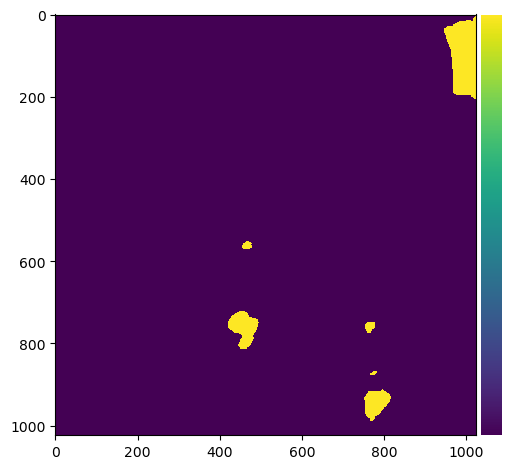

In [25]:
m = np.stack(img_anns[0]["masks"])
show_img(np.sum(m, axis=0))

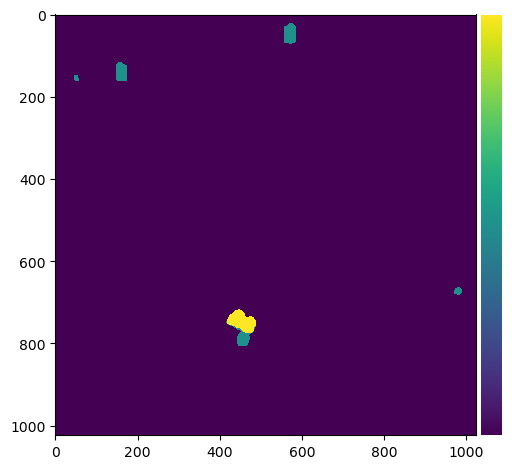

In [26]:
m = np.stack(img_anns[1]["masks"])
show_img(np.sum(m, axis=0))

check with old generation obj

In [29]:
from segment_any_change.sa_dev_v0 import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
from segment_any_change.sa_dev_v0.modeling import Sam

sam = load_sam(
            model_type=params.model_type, 
            model_cls=Sam,
            version="raw", 
            device=DEVICE
            )

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(batch["img_A"][0])

TypeError: build_sam_vit_b() got an unexpected keyword argument 'model'